In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

################################# 数据 读取-处理 开始#################################
sheet = pd.read_excel('data_input_auto/煤柴价差日度.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['华东煤油-山东柴油价差'].last_valid_index()

sheet.columns  

Index(['华东煤油-山东柴油价差', '中国煤油产量/柴油产量', '原油：主营炼厂：加工量：中国（周）', '中国主营炼厂产能利用率',
       '山东汽油裂解差', '芳烃化工品与烯烃化工品价差', 'MX（FOB韩国）-石脑油', '国内+国际航班执行数/7DMA',
       '煤油：产量：中国（周）'],
      dtype='object')

In [4]:

################################# 处理数据 让他们更适合 用来预测之后一个月的数据  #################################

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
# 所有数据截止到target_end
sheet = sheet[sheet.index <= target_end]


################################# 处理缺失值 #################################
fill_methods = {
 '中国煤油产量/柴油产量':'interpolate', 
 '原油：主营炼厂：加工量：中国（周）':'interpolate', 
 '中国主营炼厂产能利用率':'interpolate',
 '山东汽油裂解差':'interpolate', 
 '芳烃化工品与烯烃化工品价差':'interpolate', 
 'MX（FOB韩国）-石脑油':'interpolate',
 '煤油：产量：中国（周）':'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, '华东煤油-山东柴油价差'] = sheet.loc[:last_day, '华东煤油-山东柴油价差'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['中国煤油产量/柴油产量_提前25天'] = sheet['中国煤油产量/柴油产量'].shift(25)
sheet['原油：主营炼厂：加工量：中国（周）_提前20天'] = sheet['原油：主营炼厂：加工量：中国（周）'].shift(20)
sheet['中国主营炼厂产能利用率_提前20天'] = sheet['中国主营炼厂产能利用率'].shift(20)
sheet['山东汽油裂解差_提前70天'] = sheet['山东汽油裂解差'].shift(70)
sheet['芳烃化工品与烯烃化工品价差_提前40天'] = sheet['芳烃化工品与烯烃化工品价差'].shift(40)
sheet['MX（FOB韩国）-石脑油_提前60天'] = sheet['MX（FOB韩国）-石脑油'].shift(60)
sheet['煤油：产量：中国（周）_提前20天'] = sheet['煤油：产量：中国（周）'].shift(20)

################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-07-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['华东煤油-山东柴油价差'].notna())
]

################################# 数据 读取-处理 结束 #################################

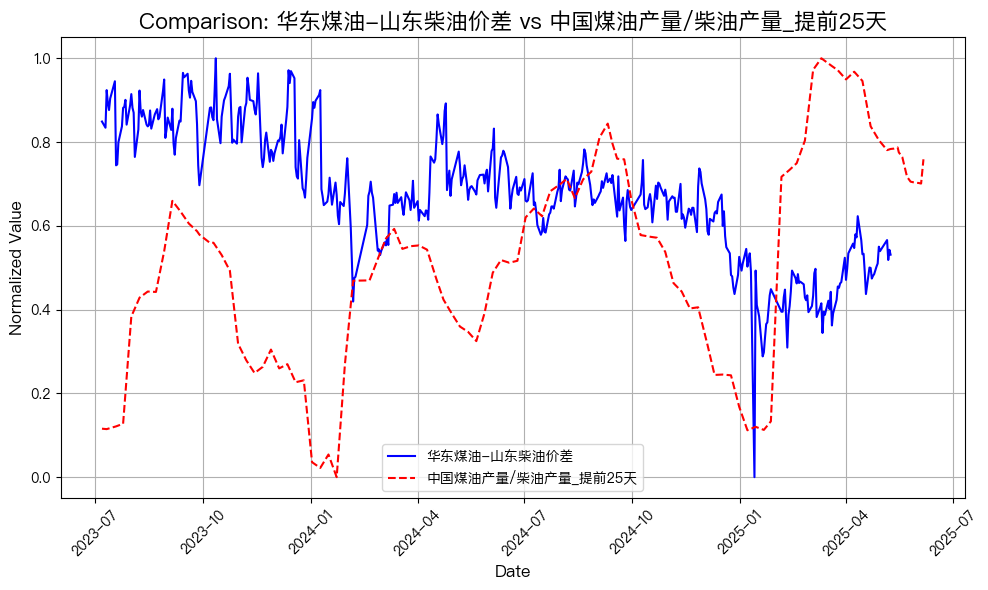

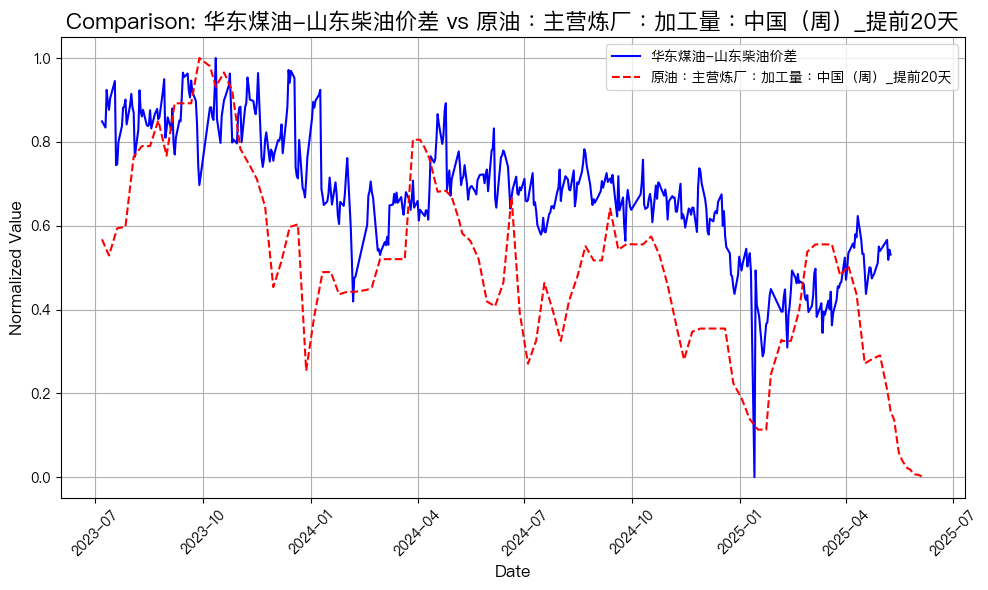

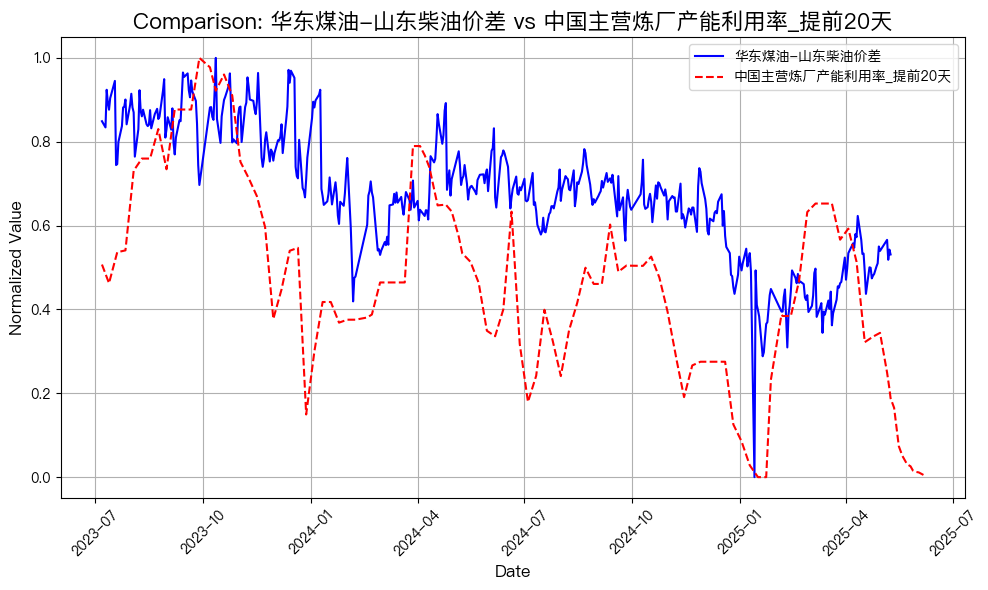

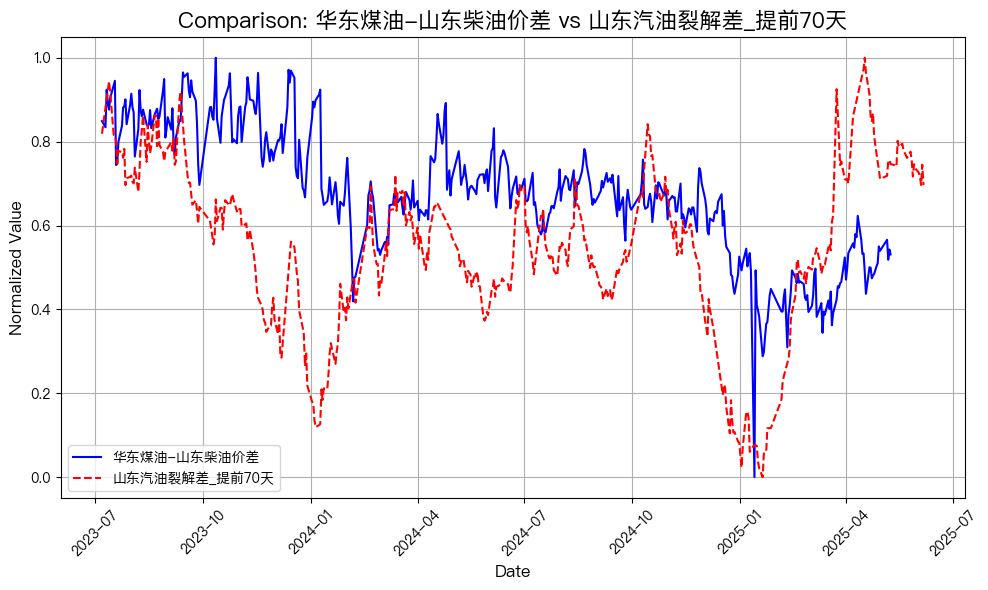

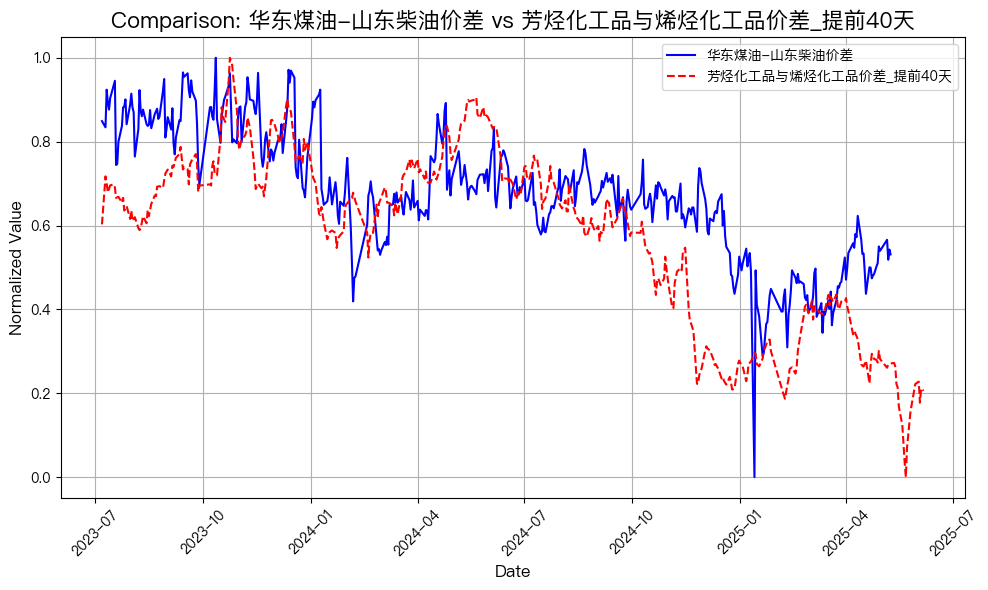

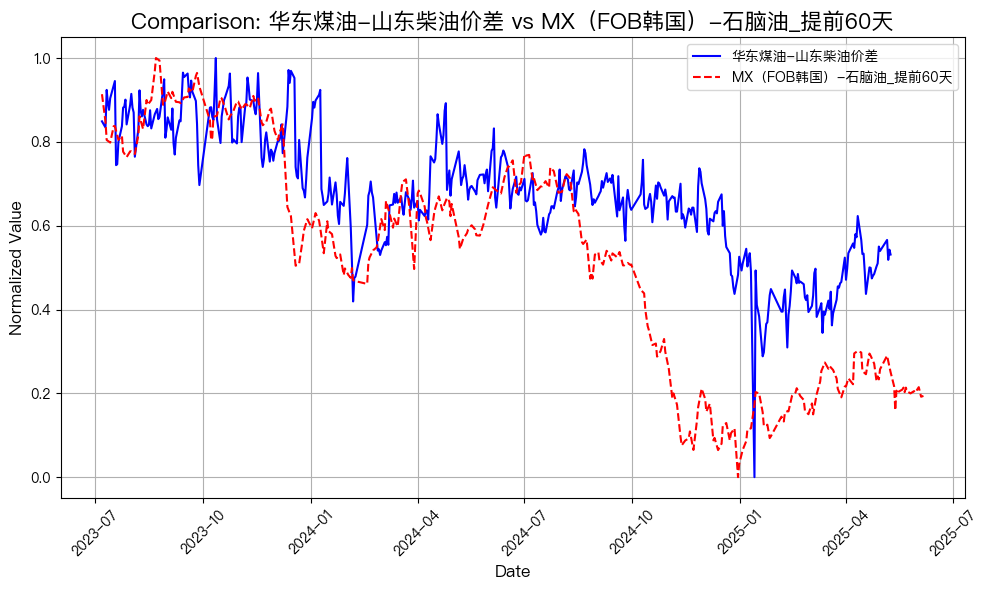

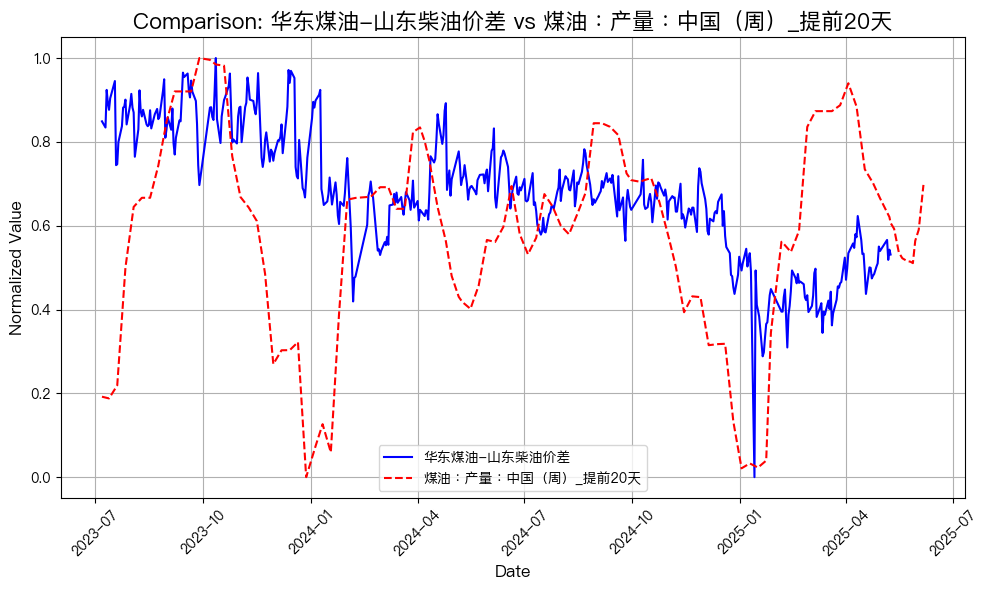

In [5]:
################################# X 和 Y 对比 观察领先性 #################################
data_filtered_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    data_filtered_plot, 
    main_col='华东煤油-山东柴油价差', 
    compare_cols=[
        '中国煤油产量/柴油产量_提前25天',
        '原油：主营炼厂：加工量：中国（周）_提前20天',
        '中国主营炼厂产能利用率_提前20天',
        '山东汽油裂解差_提前70天',
        '芳烃化工品与烯烃化工品价差_提前40天',
        'MX（FOB韩国）-石脑油_提前60天',
        '煤油：产量：中国（周）_提前20天'
        
       ]
)

In [6]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 50
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '中国煤油产量/柴油产量_提前25天',
        '原油：主营炼厂：加工量：中国（周）_提前20天',
        '中国主营炼厂产能利用率_提前20天',
        '山东汽油裂解差_提前70天',
        '芳烃化工品与烯烃化工品价差_提前40天',
        'MX（FOB韩国）-石脑油_提前60天',
        '煤油：产量：中国（周）_提前20天'
]

predict_column = '华东煤油-山东柴油价差'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 95)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 3.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.09603348960894541,  # 较小的学习率
    'max_depth': 5,  # 控制树的深度防止过拟合
    'min_child_weight': 1.86142229867777,  # 控制过拟合
    'subsample': 0.7460084570471883,  # 随机采样防止过拟合
    'colsample_bytree': 0.6932916445829455,  # 特征随机采样
    'gamma': 0.27321956853280516,  # 控制分裂
    'reg_alpha':  0.43840274447265126,  # L1正则化
    'reg_lambda':  1.495076085042001,  # L2正则化
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
 #   'max_delta_step': 5,
  #  'tree_method': 'auto'
}


num_boost_round = 5000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:213.03196	train-rmse:120.03234


[500]	eval-rmse:108.25986	train-rmse:3.13911


[1000]	eval-rmse:107.83039	train-rmse:0.59123


[1500]	eval-rmse:107.78337	train-rmse:0.44355


[2000]	eval-rmse:107.80050	train-rmse:0.41186


[2500]	eval-rmse:107.78508	train-rmse:0.39999


[3000]	eval-rmse:107.81076	train-rmse:0.39142


[3500]	eval-rmse:107.79799	train-rmse:0.38472


[4000]	eval-rmse:107.82180	train-rmse:0.37729


[4500]	eval-rmse:107.82690	train-rmse:0.37281


[4999]	eval-rmse:107.83320	train-rmse:0.36909


训练集 MSE (DMatrix): 0.1592, 训练集 R² (DMatrix): 1.0
测试集 MSE (DMatrix): 11627.9994, 测试集 R² (DMatrix): -2.1271


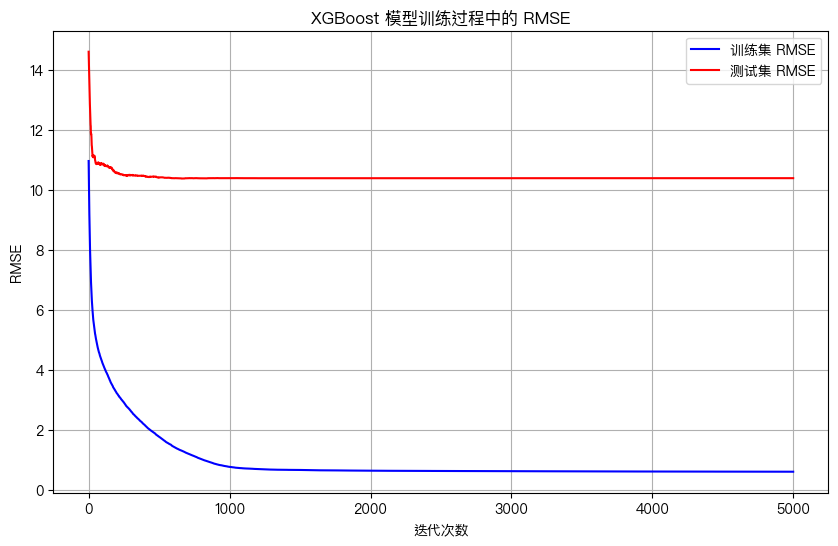

In [7]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:130.09461


[500]	train-rmse:3.68064


[1000]	train-rmse:0.72484


[1500]	train-rmse:0.44655


[2000]	train-rmse:0.41074


[2500]	train-rmse:0.39304


[3000]	train-rmse:0.38336


[3500]	train-rmse:0.37579


[4000]	train-rmse:0.36926


[4500]	train-rmse:0.36522


[4999]	train-rmse:0.36185


全部数据 MSE: 0.1389, 全部数据 R²: 1.0


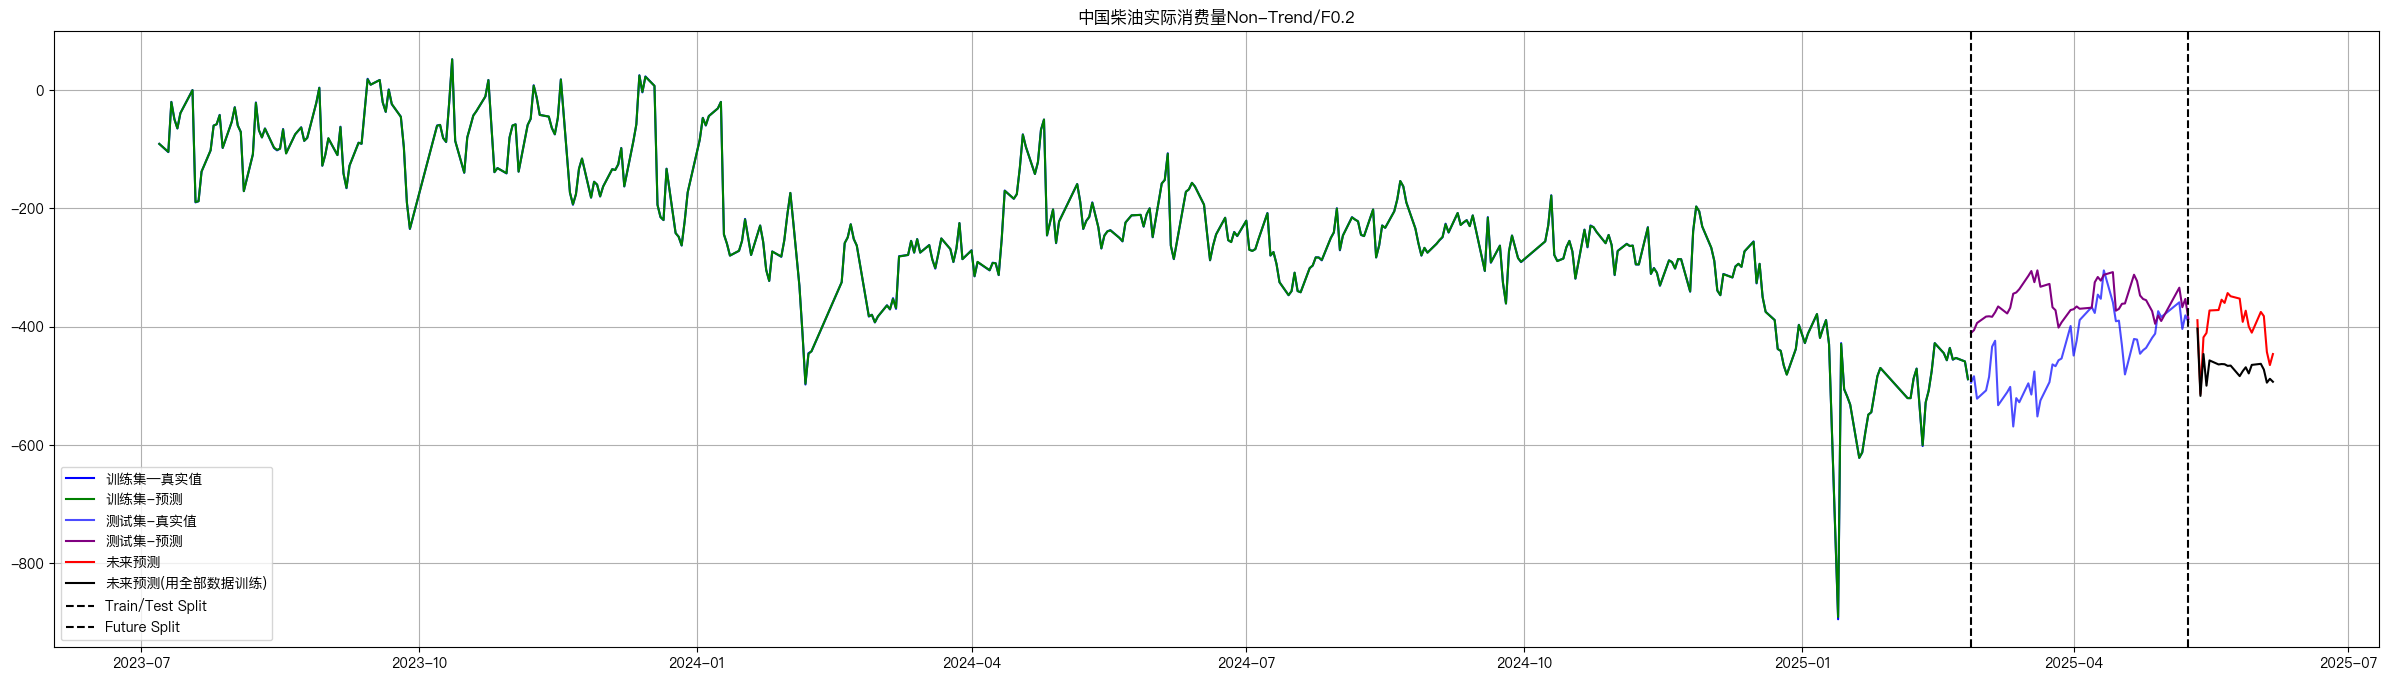

In [9]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('中国柴油实际消费量Non-Trend/F0.2')
plt.legend()
plt.grid(True)
plt.show()


---

In [10]:
################################# 训练预测数据 excel格式输出  #################################

############ 日度 数据 ############
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})

historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})

merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/华东煤油-山东柴油价差_合并数据.xlsx', index=False,float_format='%.4f')
merged_df_daily

,Date,真实值,预测值
474,2025/06/06,NaN,-493.337830
473,2025/06/05,NaN,-488.319244
472,2025/06/04,NaN,-494.860168
471,2025/06/03,NaN,-472.727356
470,2025/06/02,NaN,-463.020905
...,...,...,...
4,2023/07/13,-65.0,NaN
3,2023/07/12,-49.0,NaN
2,2023/07/11,-20.0,NaN
1,2023/07/10,-105.0,NaN


In [11]:
############ 月度 数据 ############
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
test_pred_2024 = test_data[['Date', '预测值']].copy()
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/华东煤油-山东柴油价差_月度数据.xlsx', index=False,float_format= '%.4f')
merged_df_monthly

,Date,真实值,预测值
23,2025/06/30,NaN,-482.453125
22,2025/05/31,-384.000000,-445.351562
21,2025/04/30,-400.772727,-352.591766
20,2025/03/31,-491.142857,-356.099487
19,2025/02/28,-486.210526,-470.939056
18,2025/01/31,-505.315789,-505.220337
17,2024/12/31,-349.363636,-349.375702
16,2024/11/30,-276.095238,-276.090179
15,2024/10/31,-258.473684,-258.496338
14,2024/09/30,-257.571429,-257.559326


---

In [12]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "华东煤油-山东柴油价差"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [13]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "华东煤油-山东柴油价差"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


已完成：插入/更新数据，并重新计算“方向/偏差率” (protected_date = 2025/05/31)
数据已成功更新到Excel文件
